# Method

We follow the method of Bao 2022:

- calculate advection from monthly means
- calculate eddy momentum flux from daily means
- limit this to the zonal momentum budget for now

Calculate Coriolis force, pressure gradient force and residual is not necessary hopefully.

Advection:

$$
ADV = \overline{u} \frac{\partial \overline{u}}{\partial \overline{x}} +
\overline{v} \frac{\partial \overline{u}}{\partial \overline{y}} +
\overline{\omega} \frac{\partial \overline{u}}{\partial \overline{p}}
$$

EMF (or "contribution from transient eddies")

$$
EMF = \frac{\partial \overline{u'u'}}{\partial x} +
 \frac{\partial \overline{u'v'}}{\partial y} +
  \frac{\partial \overline{u'\omega'}}{\partial p}
$$

Following Bao 2022, or Yang 2013. Overbars denote monthly means and primes denote deviations from monthly means.


## References

Bao, J., V. Dixit, and S. C. Sherwood, 2022: Zonal Temperature Gradients in the Tropical Free Troposphere. J. Climate, 35, 4337–4348, https://doi.org/10.1175/JCLI-D-22-0145.1.

Yang, W., R. Seager, and M. A. Cane, 2013: Zonal Momentum Balance in the Tropical Atmospheric Circulation during the Global Monsoon Mature Months. J. Atmos. Sci., 70, 583–599, https://doi.org/10.1175/JAS-D-12-0140.1. 

# Import Packages, Define Functions

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import metcalc
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import xesmf as xe
import dask


2022.3.0


In [3]:
def read_mm_files(filenames,index=74) :
    def preproc(ds):
        filename = ds.encoding['source']
        month=filename[index]
        if 'plev' in ds.coords :
            ds.coords['plev2'] = ds.plev / 100
            ds = ds.swap_dims({'plev': 'plev2'})
            ds.plev2['units'] = 'hPa'
        ds['month'] = int(month)
        return ds

    return xr.open_mfdataset(filenames,concat_dim="month", combine='nested',preprocess=preproc)

In [5]:
def xr_vertical_integral(ds):
    integrand = ds.sortby("plev", ascending=False).fillna(0)
    return integrand.integrate("plev")


## Monthly Mean horizontal Advection

In [ ]:
WORK_DIR = "/work/mh0066/m300577/perpetual_jan"

In [7]:
dap0013_HR = read_mm_files(f"{WORK_DIR}/dap0013-dc/dap0013-dc_ua_20N-20S_19790[2-9]_timemean.nc",index=73).sel(plev2=slice(400,150))
dap0014_HR = read_mm_files(f"{WORK_DIR}/dap0014-dc/dap0014-dc_ua_20N-20S_19790[2-9]_timemean.nc",index=73).sel(plev2=slice(400,150))
dap0013_HR["va"] = read_mm_files(f"{WORK_DIR}/dap0013-dc/dap0013-dc_va_20N-20S_19790[2-9]_timemean.nc",index=73).va.sel(plev2=slice(400,150))
dap0014_HR["va"] = read_mm_files(f"{WORK_DIR}/dap0014-dc/dap0014-dc_va_20N-20S_19790[2-9]_timemean.nc",index=73).va.sel(plev2=slice(400,150))
dap0013_HR["ta"] = read_mm_files(f"{WORK_DIR}/dap0013-dc/dap0013-dc_ta_20N-20S_19790[2-9]_timemean.nc",index=73).ta
dap0014_HR["ta"] = read_mm_files(f"{WORK_DIR}/dap0014-dc/dap0014-dc_ta_20N-20S_19790[2-9]_timemean.nc",index=73).ta
dap0013_HR["hus"] = read_mm_files(f"{WORK_DIR}/dap0013-dc/dap0013-dc_hus_20N-20S_19790[2-9]_timemean.nc",index=74).hus
dap0014_HR["hus"] = read_mm_files(f"{WORK_DIR}/dap0014-dc/dap0014-dc_hus_20N-20S_19790[2-9]_timemean.nc",index=74).hus


In [8]:
%%time
dap0013 = dap0013_HR.coarsen(lon=5, lat=5).mean().compute()
dap0014 = dap0014_HR.coarsen(lon=5, lat=5).mean().compute()

CPU times: user 10.9 s, sys: 12.2 s, total: 23.1 s
Wall time: 1min 37s


In [9]:
dap0013["Tv"] = metcalc.virtual_temperature(dap0013.ta,dap0013.hus)
dap0014["Tv"] = metcalc.virtual_temperature(dap0014.ta,dap0014.hus)
dap0013["Phi"] = metcalc.xr_geopotential(dap0013.Tv).Phi
dap0014["Phi"] = metcalc.xr_geopotential(dap0014.Tv).Phi

In [10]:
%%time
dap0013_dx = metcalc.x_derivative(dap0013,cyclic=True)
dap0014_dx = metcalc.x_derivative(dap0014,cyclic=True)

CPU times: user 21 s, sys: 18.8 ms, total: 21 s
Wall time: 21.1 s


In [11]:
%%time
dap0013_dy = metcalc.y_derivative(dap0013)
dap0014_dy = metcalc.y_derivative(dap0014)

CPU times: user 2.29 s, sys: 49.9 ms, total: 2.34 s
Wall time: 2.35 s


In [12]:
dap0013["u_du_dx"] = dap0013["ua"] * dap0013_dx["ua"]
dap0013["v_du_dy"] = dap0013["va"] * dap0013_dy["ua"]
dap0013["u_dphi_dx"] = dap0013["ua"] * dap0013_dx["Phi"]
dap0013["v_dphi_dy"] = dap0013["va"] * dap0013_dy["Phi"]


In [13]:
dap0014["u_du_dx"] = dap0014["ua"] * dap0014_dx["ua"]
dap0014["v_du_dy"] = dap0014["va"] * dap0014_dy["ua"]
dap0014["u_dphi_dx"] = dap0014["ua"] * dap0014_dx["Phi"]
dap0014["v_dphi_dy"] = dap0014["va"] * dap0014_dy["Phi"]

In [15]:
dap0013_hor_adv = dap0013["u_du_dx"] + dap0013["v_du_dy"]
dap0014_hor_adv = dap0014["u_du_dx"] + dap0014["v_du_dy"]

dap0013_temp_adv = dap0013["u_dphi_dx"] + dap0013["v_dphi_dy"]
dap0014_temp_adv = dap0014["u_dphi_dx"] + dap0014["v_dphi_dy"]

dap0013_hor_adv_tm = dap0013_hor_adv.mean("month")
dap0014_hor_adv_tm = dap0014_hor_adv.mean("month")

dap0013_temp_adv_tm = dap0013_temp_adv.mean("month")
dap0014_temp_adv_tm = dap0014_temp_adv.mean("month")

In [17]:
dap0013["ua*e"] = dap0013["ua"]/(2.*3600.*24.)
dap0014["ua*e"] = dap0014["ua"]/(2.*3600.*24.)

dap0013["Phi*e"] = dap0013["Phi"]/(2.*3600.*24.)
dap0014["Phi*e"] = dap0014["Phi"]/(2.*3600.*24.)

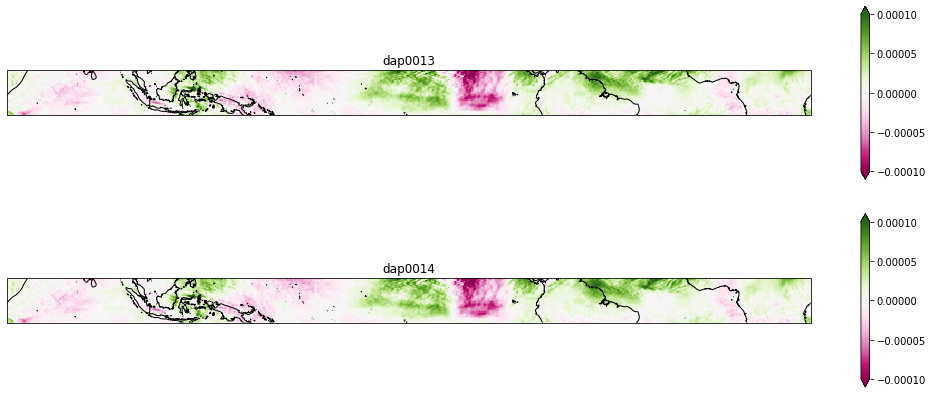

In [31]:
fig,xs = plt.subplots(2,1,figsize=(18,7), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=222)})

ax=xs[0]
im =  dap0013_hor_adv.sel(month=2).sel(plev2=300).plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=True,vmin=-1e-4,vmax=1e-4,transform=ccrs.PlateCarree())
ax.set_title("dap0013")
metcalc.set_regional_cartopy(ax,extent=[0, 359, -10, 10])

ax=xs[1]
im =  dap0013_hor_adv.sel(month=2).sel(plev2=300).plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=True,vmin=-1e-4,vmax=1e-4,transform=ccrs.PlateCarree())
ax.set_title("dap0014")
metcalc.set_regional_cartopy(ax,extent=[0, 359, -10, 10])

## Eddy Momentum Flux

Calculation takes a couple of minutes, so don't repeat it everytime!

In [33]:
recalc_EDDY = False

In [34]:
if recalc_EDDY :
    months = list(np.arange(2,10))
    
    EMF_x_list_0013 = []
    EMF_x_list_0014 = []
    EMF_y_list_0013 = []
    EMF_y_list_0014 = []
    
    for mon in months :
        with dask.config.set(**{'array.slicing.split_large_chunks': False}):
            print(mon)

            dap0013_dm_HR = xr.open_mfdataset(f"{WORK_DIR}/dap0013-dc/dap0013-dc_ua_20N-20S_19790{mon}.nc",parallel=True,chunks={"plev" : 1}).sel(plev=slice(40000,15000))
            dap0014_dm_HR = xr.open_mfdataset(f"{WORK_DIR}/dap0014-dc/dap0014-dc_ua_20N-20S_19790{mon}.nc",parallel=True,chunks={"plev" : 1}).sel(plev=slice(40000,15000))

            dap0013_dm_HR["va"] = xr.open_mfdataset(f"{WORK_DIR}/dap0013-dc/dap0013-dc_va_20N-20S_19790{mon}.nc",parallel=True,chunks={"plev" : 1}).va.sel(plev=slice(40000,15000))
            dap0014_dm_HR["va"] = xr.open_mfdataset(f"{WORK_DIR}/dap0014-dc/dap0014-dc_va_20N-20S_19790{mon}.nc",parallel=True,chunks={"plev" : 1}).va.sel(plev=slice(40000,15000))

            dap0013_dm = dap0013_dm_HR.coarsen(lon=5,lat=5).mean()
            dap0014_dm = dap0014_dm_HR.coarsen(lon=5,lat=5).mean()

            dap0013_dm_dev = dap0013_dm - dap0013_dm.mean("time")
            dap0014_dm_dev = dap0014_dm - dap0014_dm.mean("time")

            EMF_x_list_0013.append(metcalc.x_derivative((dap0013_dm_dev.ua * dap0013_dm_dev.ua).mean("time"),cyclic=True).compute())
            EMF_y_list_0013.append(metcalc.y_derivative((dap0013_dm_dev.ua * dap0013_dm_dev.va).mean("time")).compute())
            EMF_x_list_0014.append(metcalc.x_derivative((dap0014_dm_dev.ua * dap0014_dm_dev.ua).mean("time"),cyclic=True).compute())
            EMF_y_list_0014.append(metcalc.y_derivative((dap0014_dm_dev.ua * dap0014_dm_dev.va).mean("time")).compute())

    EMF_x_0013 = xr.concat(EMF_x_list_0013,xr.DataArray(months, {"month" : months}))
    EMF_x_0014 = xr.concat(EMF_x_list_0014,xr.DataArray(months, {"month" : months}))
    EMF_y_0013 = xr.concat(EMF_y_list_0013,xr.DataArray(months, {"month" : months}))
    EMF_y_0014 = xr.concat(EMF_y_list_0014,xr.DataArray(months, {"month" : months}))
    
    EMF_dap0013 = EMF_x_0013.to_dataset(name="d(u`u`)dx")
    EMF_dap0013["d(u`v`)dy"] = EMF_y_0013
    
    EMF_dap0014 = EMF_x_0014.to_dataset(name="d(u`u`)dx")
    EMF_dap0014["d(u`v`)dy"] = EMF_y_0014
                
    EMF_dap0013.to_netcdf(f"{WORK_DIR}/dap0013_hor_EMF_mm.nc")
    EMF_dap0014.to_netcdf(f"{WORK_DIR}/dap0014_hor_EMF_mm.nc")
    
else :
    EMF_dap0013 = xr.open_dataset(f"{WORK_DIR}/dap0013_hor_EMF_mm.nc")
    EMF_dap0014 = xr.open_dataset(f"{WORK_DIR}/dap0014_hor_EMF_mm.nc")
    
    

In [35]:
def corr_plev(ds) :
    ds.coords['plev2'] = ds.plev / 100
    return ds.swap_dims({'plev': 'plev2'})

EMF_dap0013_tm = corr_plev(EMF_dap0013.mean("month"))
EMF_dap0014_tm = corr_plev(EMF_dap0014.mean("month"))

EMF_dap0013_sum_tm = EMF_dap0013_tm["d(u`u`)dx"] + EMF_dap0013_tm["d(u`v`)dy"]
EMF_dap0014_sum_tm = EMF_dap0014_tm["d(u`u`)dx"] + EMF_dap0014_tm["d(u`v`)dy"]

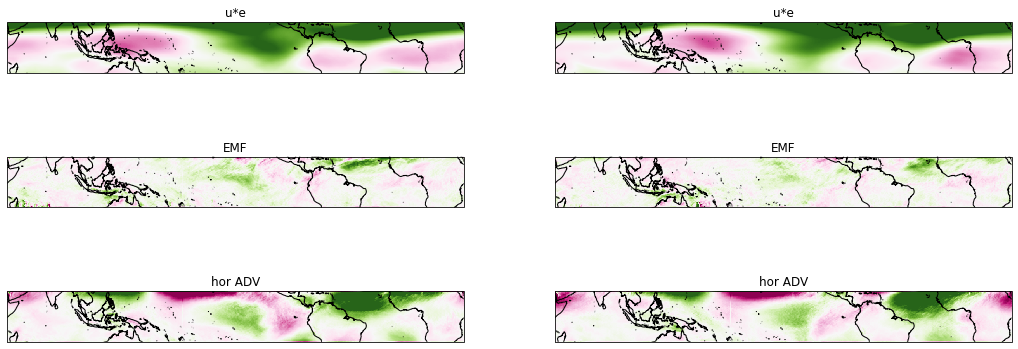

In [36]:
fig,xs = plt.subplots(3,2,figsize=(18,7), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=222)})

ax=xs[0,0]
im =  dap0013["ua*e"].mean("month").sel(plev2=300).plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=False,vmin=-1e-4,vmax=1e-4,transform=ccrs.PlateCarree())
ax.set_title("u*e")
metcalc.set_regional_cartopy(ax)

ax=xs[1,0]
im =  EMF_dap0013_sum_tm.sel(plev2=300).plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=False,vmin=-1e-4,vmax=1e-4,transform=ccrs.PlateCarree())
ax.set_title("EMF")
metcalc.set_regional_cartopy(ax)


ax=xs[2,0]
im =  dap0013_hor_adv_tm.sel(plev2=300).plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=False,vmin=-1e-4,vmax=1e-4,transform=ccrs.PlateCarree())
ax.set_title("hor ADV")
metcalc.set_regional_cartopy(ax)


ax=xs[0,1]
im =  dap0014["ua*e"].mean("month").sel(plev2=300).plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=False,vmin=-1e-4,vmax=1e-4,transform=ccrs.PlateCarree())
ax.set_title("u*e")
metcalc.set_regional_cartopy(ax)

ax=xs[1,1]
im =  EMF_dap0014_sum_tm.sel(plev2=300).plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=False,vmin=-1e-4,vmax=1e-4,transform=ccrs.PlateCarree())
ax.set_title("EMF")
metcalc.set_regional_cartopy(ax)


ax=xs[2,1]
im =  dap0014_hor_adv_tm.sel(plev2=300).plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=False,vmin=-1e-4,vmax=1e-4,transform=ccrs.PlateCarree())
ax.set_title("hor ADV")
metcalc.set_regional_cartopy(ax)


## Read Gill model

In [38]:
def gill_coord(ds,dap_LR) :
    sims_20 = ds.isel(x=slice(1,-1),y=slice(6,26)) # for 2x2 res
    sims_20 = sims_20.assign_coords(lon = ("x", dap_LR.lon.values)).assign_coords(lat = ("y", dap_LR.lat.values))
    sims_20 = sims_20.swap_dims({"x": "lon"}).swap_dims({"y": "lat"})
    return sims_20

In [39]:
gill_01_ = xr.open_dataset("/work/mh0066/m300577/numerical_gill/data/sims_monte_carlo_400-150_FFT/delta_pr_non_dim_400-150_30N-30S_FFT_epsilon_p=0.1_epsilon_u=0.1_epsilon_v=0.1_f=gill_res=2.nc")
gill_01 = gill_coord(gill_01_,dap_LR)
T = 20664.
L = 1052021.
gill_01_u_redim = gill_01.u * (L/T)

gill_ue = gill_01_u_redim/ (2.*3600.*24.)

## Calculate 400-150hpa differences

In [40]:
dap0013_400_150 = (dap0013["ua*e"].mean("month").sel(plev2=150) - dap0013["ua*e"].mean("month").sel(plev2=400)).to_dataset(name="ua*e")
dap0013_400_150["Phi*e"] = (dap0013["Phi*e"].mean("month").sel(plev2=150) - dap0013["Phi*e"].mean("month").sel(plev2=400))
dap0013_400_150["hor_ADV"] = dap0013_hor_adv_tm.sel(plev2=150) - dap0013_hor_adv_tm.sel(plev2=400)
dap0013_400_150["EMF"] = EMF_dap0013_sum_tm.sel(plev2=150) - EMF_dap0013_sum_tm.sel(plev2=400)
dap0013_400_150["temp_ADV"] = dap0013_temp_adv_tm.sel(plev2=150) - dap0013_temp_adv_tm.sel(plev2=400)

dap0014_400_150 = (dap0014["ua*e"].mean("month").sel(plev2=150) - dap0014["ua*e"].mean("month").sel(plev2=400)).to_dataset(name="ua*e")
dap0014_400_150["Phi*e"] = (dap0014["Phi*e"].mean("month").sel(plev2=150) - dap0014["Phi*e"].mean("month").sel(plev2=400))
dap0014_400_150["hor_ADV"] = dap0014_hor_adv_tm.sel(plev2=150) - dap0014_hor_adv_tm.sel(plev2=400)
dap0014_400_150["EMF"] = EMF_dap0014_sum_tm.sel(plev2=150) - EMF_dap0014_sum_tm.sel(plev2=400)
dap0014_400_150["temp_ADV"] = dap0014_temp_adv_tm.sel(plev2=150) - dap0014_temp_adv_tm.sel(plev2=400)

dap_diff_400_150 = dap0014_400_150 - dap0013_400_150

global warming differences on each level

In [41]:
dap_diff = (dap0014_hor_adv_tm - dap0013_hor_adv_tm).to_dataset(name="hor_ADV")
dap_diff["EMF"] = EMF_dap0014_sum_tm - EMF_dap0013_sum_tm

# Plot

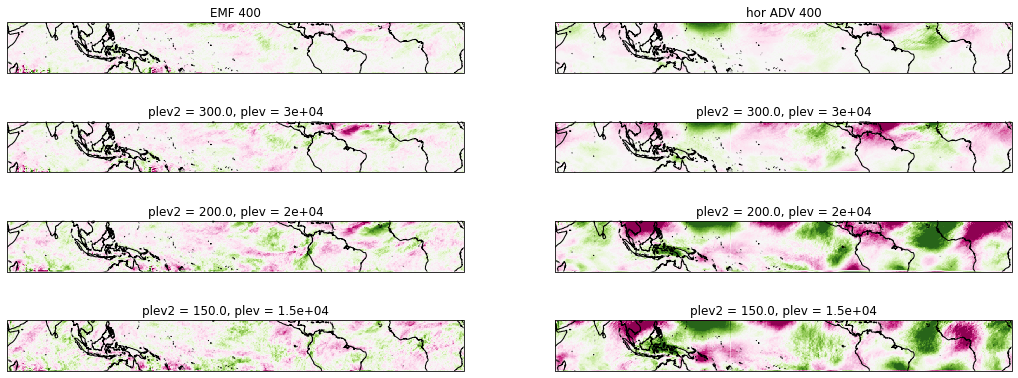

In [42]:
fig,xs = plt.subplots(4,2,figsize=(18,7), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=222)})


ax=xs[0,0]
im =  dap_diff["EMF"].sel(plev2=400).plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=False,vmin=-1e-4,vmax=1e-4,transform=ccrs.PlateCarree())
ax.set_title("EMF 400")
metcalc.set_regional_cartopy(ax)

ax=xs[1,0]
im =  dap_diff["EMF"].sel(plev2=300).plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=False,vmin=-1e-4,vmax=1e-4,transform=ccrs.PlateCarree())
metcalc.set_regional_cartopy(ax)

ax=xs[2,0]
im =  dap_diff["EMF"].sel(plev2=200).plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=False,vmin=-1e-4,vmax=1e-4,transform=ccrs.PlateCarree())
metcalc.set_regional_cartopy(ax)

ax=xs[3,0]
im =  dap_diff["EMF"].sel(plev2=150).plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=False,vmin=-1e-4,vmax=1e-4,transform=ccrs.PlateCarree())
metcalc.set_regional_cartopy(ax)

ax=xs[0,1]
im =  dap_diff["hor_ADV"].sel(plev2=400).plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=False,vmin=-1e-4,vmax=1e-4,transform=ccrs.PlateCarree())
ax.set_title("hor ADV 400")
metcalc.set_regional_cartopy(ax)

ax=xs[1,1]
im =  dap_diff["hor_ADV"].sel(plev2=300).plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=False,vmin=-1e-4,vmax=1e-4,transform=ccrs.PlateCarree())
metcalc.set_regional_cartopy(ax)

ax=xs[2,1]
im =  dap_diff["hor_ADV"].sel(plev2=200).plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=False,vmin=-1e-4,vmax=1e-4,transform=ccrs.PlateCarree())
metcalc.set_regional_cartopy(ax)

ax=xs[3,1]
im =  dap_diff["hor_ADV"].sel(plev2=150).plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=False,vmin=-1e-4,vmax=1e-4,transform=ccrs.PlateCarree())
metcalc.set_regional_cartopy(ax)


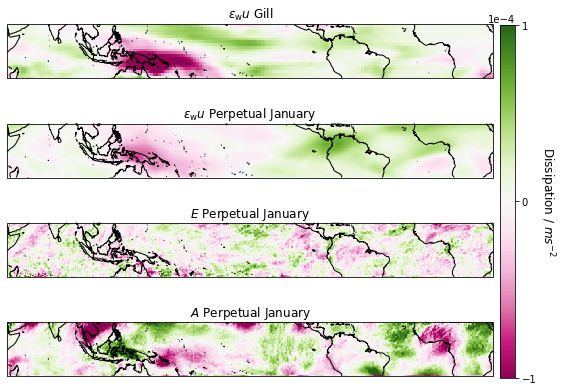

In [44]:
fig,xs = plt.subplots(4,1,figsize=(10,7), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=222)})

ax=xs[0]
im =  gill_ue.plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=False,vmin=-1e-4,vmax=1e-4,transform=ccrs.PlateCarree())
ax.set_title("$\epsilon_\mathrm{w} u$ Gill")
metcalc.set_regional_cartopy(ax)


ax=xs[1]
im =  dap_diff_400_150["ua*e"].plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=False,vmin=-1e-4,vmax=1e-4,transform=ccrs.PlateCarree())
ax.set_title("$\epsilon_\mathrm{w} u$ Perpetual January")
metcalc.set_regional_cartopy(ax)

ax=xs[2]
im =  dap_diff_400_150["EMF"].plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=False,vmin=-1e-4,vmax=1e-4,transform=ccrs.PlateCarree())
ax.set_title("$E$ Perpetual January")
metcalc.set_regional_cartopy(ax)


ax=xs[3]
im =  dap_diff_400_150["hor_ADV"].plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=False,vmin=-1e-4,vmax=1e-4,transform=ccrs.PlateCarree())
ax.set_title("$A$ Perpetual January")
metcalc.set_regional_cartopy(ax)

cbar = metcalc.good_colorbar(im,fig,"Dissipation / $ m s^{-2}$",label_kwargs={"labelpad": 20,"size" : 12},cb_kwargs={"ticks" : [-1e-4,0,1e-4]})
cbar.formatter.set_powerlimits((0, 0))

plt.savefig('../plots/figure_ADV_EMF.png', dpi=600,bbox_inches='tight')


# Horizontal Temperature Advection

In [47]:
gill_01_Phi_redim = gill_01.p * 2800.
gill_phie = gill_01_Phi_redim/ (2.*3600.*24.)

In [78]:
dap_diff_400_150["Phi*e"].plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=True)

In [91]:
def anomaly_from_tropical_mean(ds, lat=20) :
    return ds.sel(lat=slice(-lat,lat)) - metcalc.xr_fldmean(ds.sel(lat=slice(-lat,lat)))

In [92]:
dap_diff_400_150_an = anomaly_from_tropical_mean(dap_diff_400_150)

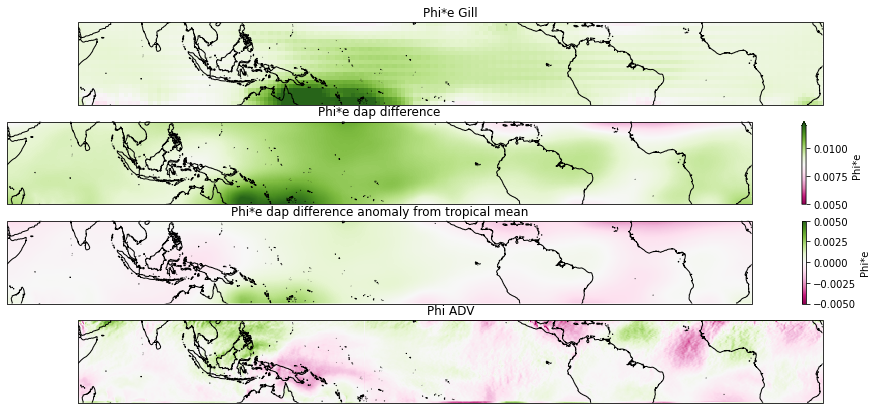

In [98]:
fig,xs = plt.subplots(4,1,figsize=(18,7), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=222)})

ax=xs[0]
im =  gill_phie.plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=False,vmin=-0.005,vmax=0.005,transform=ccrs.PlateCarree())
ax.set_title("Phi*e Gill")
metcalc.set_regional_cartopy(ax)

ax=xs[1]
im =  dap_diff_400_150["Phi*e"].plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=True,vmin=0.005,vmax=0.012,transform=ccrs.PlateCarree())
ax.set_title("Phi*e dap difference")
metcalc.set_regional_cartopy(ax)

ax=xs[2]
im =  dap_diff_400_150_an["Phi*e"].plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=True,vmin=-0.005,vmax=0.005,transform=ccrs.PlateCarree())
ax.set_title("Phi*e dap difference anomaly from tropical mean")
metcalc.set_regional_cartopy(ax)

ax=xs[3]
im = dap_diff_400_150["temp_ADV"].plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=False,vmin=-0.005,vmax=0.005,transform=ccrs.PlateCarree())
ax.set_title("Phi ADV")
metcalc.set_regional_cartopy(ax)
